**LSTM** (Long Short Term Memory) is a type of **RNN** (Recurrent Neural Network) for learning sequence data (such **time series**) where the data has **dependency** on previous observations.

This example use past few days close price of Bitcoin to predict next day close price (**one-step forecast**).


*   Past few days closing price -> Next day closing price


It's an **univariate** (i.e. a single feature of close price) example. For more details: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

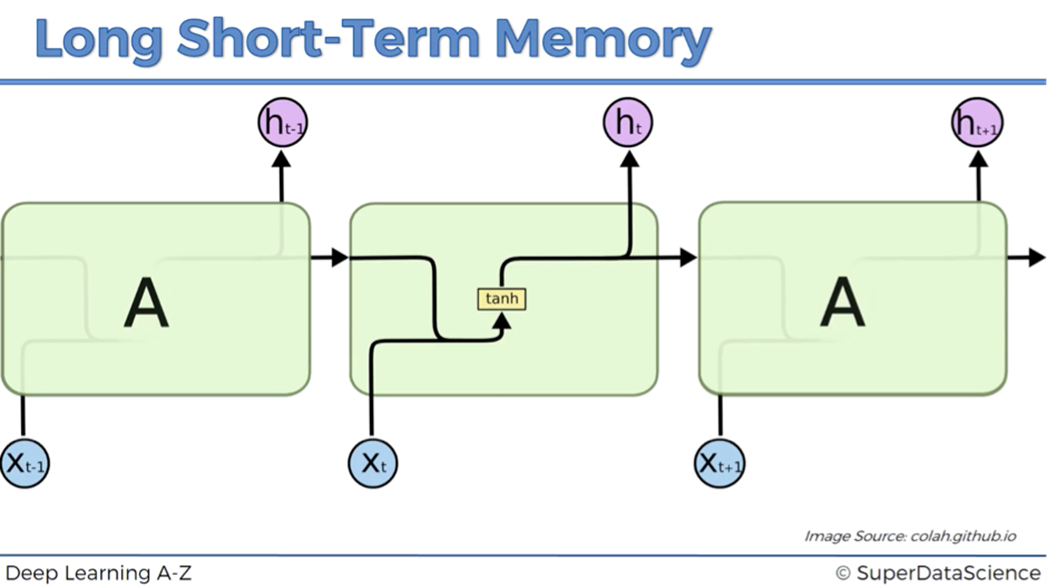


In [ ]:
#@title Execute this block to import TensorFlow deep learning library and helper functions

import datetime
import statistics as stats
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

def CryptoData(symbol, frequency, start=0):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start='+str(start)
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)

  yhat = lstm.predict(x_seq)
  y = raw_seq[index]

  return x_seq, yhat, y


# predict the next day close as the same as today's close
def getBasePrediction(raw_seq, index, n_steps):
  x_seq = raw_seq[index-n_steps : index]

  yhat = x_seq[len(x_seq)-1]
  y = raw_seq[index]

  return x_seq, yhat, y


def roundNum(num, dp=2):
	return round(num, dp)

In [ ]:
#@title Source the daily bitcoin data

startDate = int((datetime.datetime.strptime('1/1/2018', "%d/%m/%Y").timestamp()))
testSymbol = 'USDT_BTC' #bitCoin
# frequency = 86400s which is 1 day
df = CryptoData(testSymbol, 86400, startDate)
df



In [ ]:
#@title Plot the bitcoin closing price
df['close'].plot(figsize = (SCREEN_X, SCREEN_Y))

# Prepare the dataset (using closing price feature only)

Split the data into training and test set

* If the samples in the dataset are **independent** of each other (e.g. faces and people names), training and test set can be **randomly split**.

* For time series data, usually **split according to the time period** where the **earlier period is the training set**.


In [ ]:
#@title Choose the training dataset ratio

train_ratio = 0.8 #@param {type:"slider", min:0.5, max:0.9, step:0.05}

# define input sequence and no. of features
# Use only the "close" price as the input feature
raw_seq = df['close'].values
n_features = raw_seq.ndim
data_size = len(raw_seq)

print("data_size:", data_size)

train_size = round(train_ratio * data_size)
train_seq = raw_seq[:train_size]
test_seq = raw_seq[train_size:]

print("train_size:", train_size)
print("test_size:", data_size-train_size)

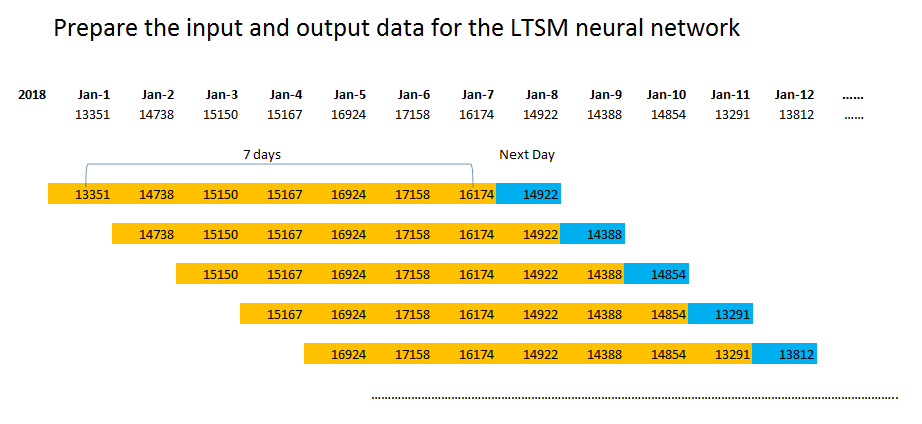

In [ ]:
#@title Choose a number of time steps (how many previous closing price to predict the next day closing price)

n_steps = 7 #@param {type:"integer"}

# split into training samples
x_train, y_train = split_sequence(train_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

print("training data input:", x_train.shape)
print("training data output`:", y_train.shape)


In [ ]:
#@title Show one sample of the input and output from the training data

training_sampe = 0 #@param {type:"integer"}

print(x_train[training_sampe])
print('--->', y_train[training_sampe])

In [ ]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 1) + 32) = 4352

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#@title Train the LSTM Neural Network with the input number of epochs

epochs = 20 #@param {type:"integer"}

# fit model
history = model.fit(x_train, y_train, epochs=epochs)

# Plot the loss
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
#@title Pick one sample from the testing data to verify the prediction

test_day = 0 #@param {type:"integer"}

# predict the next day
index = test_day + train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

predicted = yhat[0][0]
actual = y
error = actual - predicted
errorP = abs(error) / predicted

print(x_seq, "\n")
print("Predicted:", predicted)
print("Actual:", actual)
print("Error:", error)
print("Error%:", roundNum(errorP, 4)*100)

In [ ]:
#@title Plot the predicted values (in testing data) vs the actual values
predictedList = []
actualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

# plot the result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="Predicted")
plt.plot(actualList, label="Actual")
plt.legend()

# Each prediction is based on the "actual" observation from the past days
# Another way is to use multi-step ahead output or use the predicted values as new observations to further predict the rest of the series


In [ ]:
#@title Print the testing and actual values comparisons
lstmError = []
lstmErrorP = []
for i in range(len(predictedList)):
  error = actualList[i]-predictedList[i]
  absError = abs(error)
  errorP = absError/actualList[i]
  lstmError.append(absError)
  lstmErrorP.append(errorP)

  print("Predicted:", roundNum(predictedList[i]),
       "  Actual:", roundNum(actualList[i]),
       "  Error:", roundNum(error),
        "->", roundNum(errorP), sep='')

print("------------------------------------------------------------------")
print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

In [ ]:
#@title Baseline comparison: predict the next day closing price as the same as today's closing price
basePredictedList = []
baseActualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
  basePredictedList.append(yhat)
  baseActualList.append(y)


# look at the individual predictions
baseError = []
baseErrorP = []
for i in range(len(basePredictedList)):
  error = baseActualList[i]-basePredictedList[i]
  absError = abs(error)
  errorP = absError/baseActualList[i]
  baseError.append(absError)
  baseErrorP.append(errorP)

  print("Predicted:", roundNum(basePredictedList[i]),
       "  Actual:", roundNum(baseActualList[i]),
       "  Error:", roundNum(error),
        "->", roundNum(errorP), sep='')

print("------------------------------------------------------------------")
print("Baseline Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
print("Baseline Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')

print("------------------------------------------------------------------")
print("LSTM Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("LSTM Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

In [ ]:
#@title Plot the predicted values (in testing data) vs the actual values
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(basePredictedList, label="Predicted")
plt.plot(baseActualList, label="Actual")
plt.legend()

In [ ]:
#@title Plot all results
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="LSTM")
plt.plot(basePredictedList, label="Base")
plt.plot(baseActualList, label="Actual")
plt.legend()

# Notes

*   Use more data features
*   Closing price is non-stationary and it more commonly to use **log-return**
